# Выполнил: Филоненко Никита

-----

**Решение на GitHub**



# Содержание
#### [**Задание**](#01)

1. [**Load data & EDA**](#02)

2. [**Data preprocessing**](#03)

3. [**`PTLS` и создание эмбеддингов на основе последовательностей дискретных событий**](#04)

4. [**Обучение random forest**](#05)
   - [**Эксперимент №1**](#05.1)
   - [**Эксперимент №2**](#05.2)

## Задание

- Взять за основу демо с примером работы нашего алгоритма: `https://github.com/dllllb/pytorch-lifestream/blob/main/demo/coles-emb.ipynb`
- Переделать его, применить алгоритм к другому датасету (на выбор)
- Улучшить решение

Улучшать решение можно двумя способами:
1. Тюнинг гипперпараметров
2. Изменить подход к решению
Второе предпочтительнее.


### Бизнес-задача (исходя из выбранного мною набора данных)

- Определить, к какому сегменту относится клиент, чтобы персонализировать предложения и увеличить лояльность клиентов, а также максимизировать доход компании

-----

### План выполнения

- **провести анализ и подготовку данных** (EDA, общее представление, содержательные и статические характеристики, нормальность распределения данных, энкодинг категориальных признаков и тд)

- **сгенерировать эмбеддинги на основе последовательностей дискретных событий с помощью `PTLS`**

- **обучить на полученных эмбеддингах `random forest`** для сегментации клиентов на основе их покупательского поведения с целью улучшения таргетинга маркетинговых кампаний и персонализированного обслуживания



## Решение

## 1. **Load data & EDA**

-----

Так как библиотека **PTLS** предназначена для работы с событийными данными, я решил остановить свое внимание на датасете [Retail_Transaction](https://www.kaggle.com/datasets/fahadrehman07/retail-transaction-dataset) (набор данных о розничных транзакциях), который содержит:

- информацию о поведении потребителей,
- предпочтениях продуктов,
- ценовых стратегиях и региональных тенденциях в розничной среде,
- динамике розничной торговли,
- суть транзакций в розничной среде.


- **Импортируем необходимые модули**

In [1]:
import sys
if 'google.colab' in str(get_ipython()):
    ! {sys.executable} -m pip install pytorch-lifestream
    ! {sys.executable} -m pip install colorama

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.4/163.4 kB 11.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 48.0 MB/s eta 0:00:00
  Created wheel for pytorch-lifestream: filename=pytorch_lifestream-0.6.0-py3-none-any.whl size=274602 sha256=9b4aba8852f9dde6e2a95b2833848234864a618e8af205853840413d9c9b3bc8
  Stored in directory: /root/.cache/pip/wheels/90/76/b4/0a944bc7c5a69201e4d757cc54886971117a2a581740e7f11d
  Created wheel for antlr4-python3-runtime: filename=ant

In [1]:
%load_ext autoreload
%autoreload 2

# import logging
import torch
import pytorch_lightning as pl
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore, Style

# import warnings
# warnings.filterwarnings('ignore')
# logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

- **Получение общего представления о данных (Пропуски, дубликаты, datatypes)**

In [ ]:
data = pd.read_csv("../../src/data/Retail_Transaction_Dataset.csv", sep=',')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 828328 entries, 0 to 828327
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   CustomerID          828328 non-null  int64  
 1   ProductID           828328 non-null  object 
 2   Quantity            828328 non-null  int64  
 3   Price               828328 non-null  float64
 4   TransactionDate     828328 non-null  object 
 5   PaymentMethod       828328 non-null  object 
 6   StoreLocation       828328 non-null  object 
 7   ProductCategory     828328 non-null  object 
 8   DiscountApplied(%)  828328 non-null  float64
 9   TotalAmount         828328 non-null  float64
dtypes: float64(3), int64(2), object(5)
memory usage: 63.2+ MB


**Столбцы:**

`CustomerID`: Уникальный идентификатор для каждого клиента.

`ProductID`: Идентификатор для каждого ценового сегмента продукта.

`Quantity`: Количество единиц, приобретенных для определенного продукта.

`Price`: Цена единицы товара.

`TransactionDate`: Дата и время, когда произошла транзакция.

`PaymentMethod`: Метод, используемый клиентом для совершения платежа.

`StoreLocation`: Местоположение, где была совершена транзакция.

`ProductCategory`: Категория, к которой относится продукт.

`DiscountApplied(%)`: Процент от скидки, применяемой к продукту.

`TotalAmount`: Общая сумма, уплаченная за транзакцию.

In [ ]:
data.head(5)

,CustomerID,ProductID,Quantity,Price,TransactionDate,PaymentMethod,StoreLocation,ProductCategory,DiscountApplied(%),TotalAmount
0,109318,C,7,80.079844,2023-12-26 12:32:00,Cash,"176 Andrew Cliffs\nBaileyfort, HI 93354",Books,18.677100,455.862764
1,993229,C,4,75.195229,2023-08-05 00:00:00,Cash,"11635 William Well Suite 809\nEast Kara, MT 19483",Home Decor,14.121365,258.306546
2,579675,A,8,31.528816,2024-03-11 18:51:00,Cash,"910 Mendez Ville Suite 909\nPort Lauraland, MO...",Books,15.943701,212.015651
3,799826,D,5,98.880218,2023-10-27 22:00:00,PayPal,"87522 Sharon Corners Suite 500\nLake Tammy, MO...",Books,6.686337,461.343769
4,121413,A,7,93.188512,2023-12-22 11:38:00,Cash,"0070 Michelle Island Suite 143\nHoland, VA 80142",Electronics,4.030096,626.030484


In [ ]:
data.dtypes

CustomerID              int64
ProductID              object
Quantity                int64
Price                 float64
TransactionDate        object
PaymentMethod          object
StoreLocation          object
ProductCategory        object
DiscountApplied(%)    float64
TotalAmount           float64
dtype: object

In [ ]:
data.isna().sum()

CustomerID            0
ProductID             0
Quantity              0
Price                 0
TransactionDate       0
PaymentMethod         0
StoreLocation         0
ProductCategory       0
DiscountApplied(%)    0
TotalAmount           0
dtype: int64

In [ ]:
data["TransactionDate"].head(1)

0    2023-12-26 12:32:00
Name: TransactionDate, dtype: object

**Исходя из полученной информации можно сделать вывод, что пропусков в данных нет, однако, я заметил, что столбец *`TransactionDate`* имеет некорректный datatype для отображения даты (в виде строки), чтобы избежать ряда проблем (например, при работе с временными интервалами) нужно его преобразовать в тип данных `datetime`**


- **Преобразуем столбец `TransactionDate` в нужный тип данных:**

In [ ]:
data['TransactionDate'] = pd.to_datetime(data['TransactionDate'])

data.dtypes

CustomerID                     int64
ProductID                     object
Quantity                       int64
Price                        float64
TransactionDate       datetime64[ns]
PaymentMethod                 object
StoreLocation                 object
ProductCategory               object
DiscountApplied(%)           float64
TotalAmount                  float64
dtype: object

In [ ]:
data['TransactionDate'].head()

0   2023-12-26 12:32:00
1   2023-08-05 00:00:00
2   2024-03-11 18:51:00
3   2023-10-27 22:00:00
4   2023-12-22 11:38:00
Name: TransactionDate, dtype: datetime64[ns]

- **Проверим ***наличие дубликатов*** в данных**

In [ ]:
data.duplicated().sum()

0

### **Проведем базовый EDA, чтобы узнать получше о наборе данных**

**Первоначально проверим согласованность и точность имеющихся данных**

Нужно:

-  Проверить столбец `TotalAmount` на соответствие формуле рассчета **Quantity * Price * (1 - DiscountApplied/100)**

- Проверить аномалии в данных, такие как нулевые или отрицательные значения в столбцах `Quantity` и `Price`

- Проверить, что значения в столбце `DiscountApplied(%)` находятся в пределах от 0 до 100

- Стандартизировать формат данных в столбце `StoreLocation`

In [ ]:
# 1. Проверка корректности TotalAmount без создания новых столбцов
calculated_total = data['Quantity'] * data['Price'] * (1 - data['DiscountApplied(%)'] / 100)

discrepancies = data[np.abs(data['TotalAmount'] - calculated_total) > 1e-2]

print(f"Обнаружено {Fore.LIGHTGREEN_EX}{len(discrepancies)}{Style.RESET_ALL} расхождений между 'TotalAmount' и рассчитанным значением.\n")

# 2. Проверка аномалий в столбцах Quantity и Price
quantity_anomalies = data[data['Quantity'] <= 0]
price_anomalies = data[data['Price'] <= 0]

print(f"Обнаружено {Fore.LIGHTGREEN_EX}{len(quantity_anomalies)}{Style.RESET_ALL} аномалий с нулевыми или отрицательными значениями в столбце 'Quantity'.\n" )

print(f"Обнаружено {Fore.LIGHTGREEN_EX}{len(price_anomalies)}{Style.RESET_ALL} аномалий с нулевыми или отрицательными значениями в столбце 'Price'.\n")


# 3. Проверка значений в столбце DiscountApplied(%)
discount_anomalies = data[(data['DiscountApplied(%)'] < 0) | (data['DiscountApplied(%)'] > 100)]

print(f"Обнаружено {Fore.LIGHTGREEN_EX}{len(discount_anomalies)}{Style.RESET_ALL} аномальных значений в столбце 'DiscountApplied(%)'.\n")


Обнаружено 0 расхождений между 'TotalAmount' и рассчитанным значением.

Обнаружено 0 аномалий с нулевыми или отрицательными значениями в столбце 'Quantity'.

Обнаружено 0 аномалий с нулевыми или отрицательными значениями в столбце 'Price'.

Обнаружено 0 аномальных значений в столбце 'DiscountApplied(%)'.


#### **Далее, получим несколько содержательных характеристик о нашем датасете**

- **Кол-во категорий товаров**

In [ ]:
data.ProductCategory.unique()

array(['Books', 'Home Decor', 'Electronics', 'Clothing'], dtype=object)

Text(0.5, 0, 'Частота')

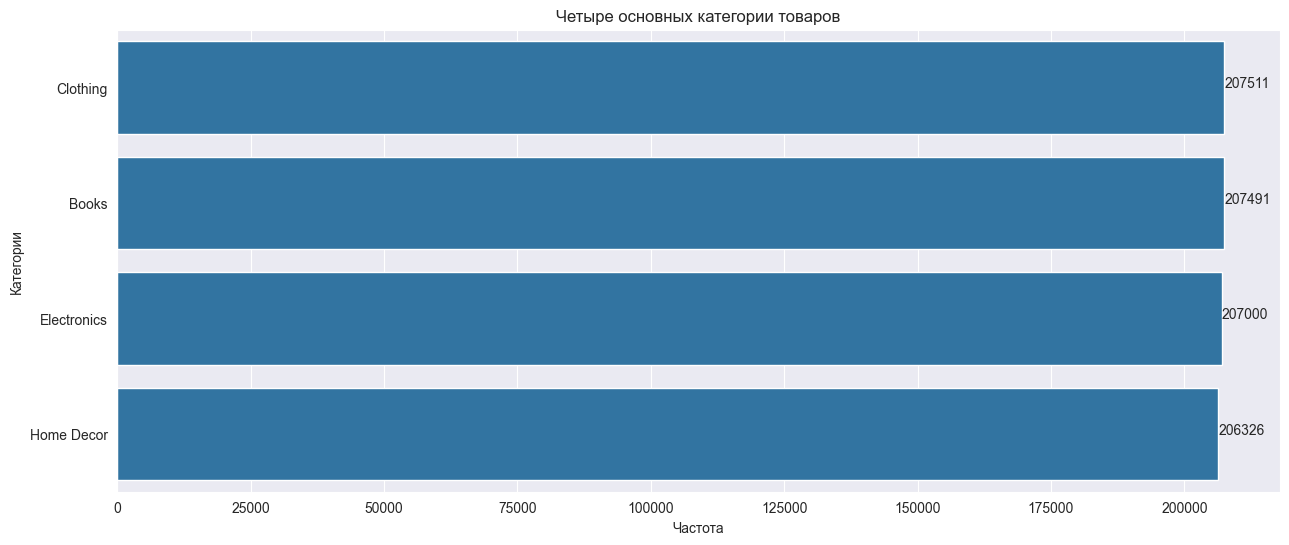

In [ ]:
product_category_counts = data.ProductCategory.value_counts()

plt.figure(figsize=(15,6))
ax = sns.barplot(x=product_category_counts.values, y=product_category_counts.index)

for i, count in enumerate(product_category_counts.values):
    ax.text(count + 0.1, i, str(count), ha='left')


plt.title("Четыре основных категории товаров")
plt.ylabel("Категории")
plt.xlabel("Частота")

- Наиболее часто покупаемая категория товаров

In [ ]:
product_category_counts = data['ProductCategory'].value_counts()

most_common_product_category = product_category_counts.idxmax()
most_common_product_category_counts = product_category_counts.max()

print(f"Наиболее часто покупаемая категория товаров: \n\n{Fore.BLUE}{most_common_product_category}{Style.RESET_ALL} (Количество: {Fore.LIGHTGREEN_EX}{most_common_product_category_counts}{Style.RESET_ALL})")

Наиболее часто покупаемая категория товаров: 

Clothing (Количество: 207511)


Как можно заметить, **дисбаланс данных** между категориями товаров **отсутствует**

- **Какой способ оплаты является наиболее часто используемым**

In [ ]:
data.PaymentMethod.unique()

array(['Cash', 'PayPal', 'Debit Card', 'Credit Card'], dtype=object)

Text(0, 0.5, 'Частота')

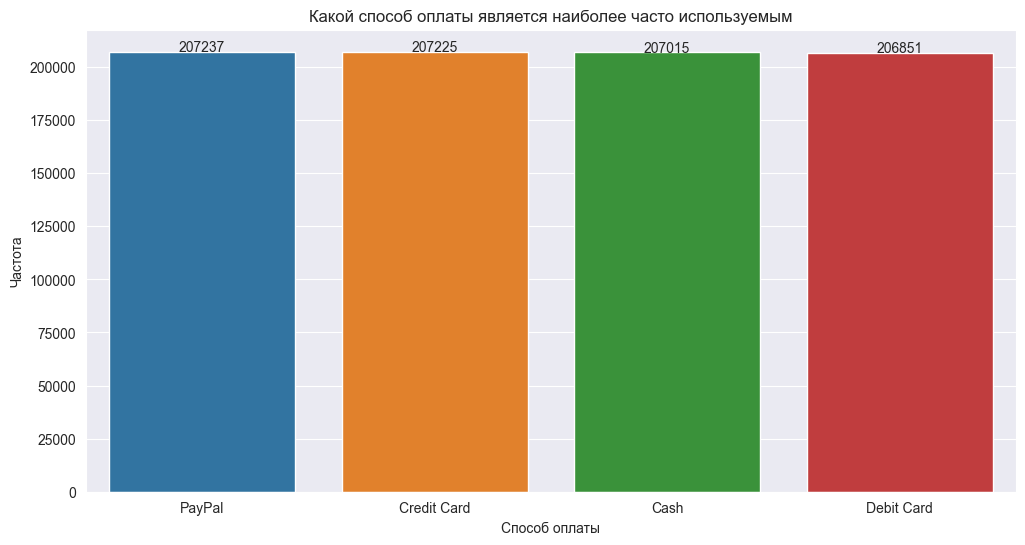

In [ ]:
payment_method_counts = data.PaymentMethod.value_counts()

plt.figure(figsize=(12, 6))

colors = ['red', 'blue', 'green', 'orange']
ax = sns.barplot(x=payment_method_counts.index, y=payment_method_counts.values, hue=payment_method_counts.index)

plt.title("Какой способ оплаты является наиболее часто используемым")

for i, count in enumerate(payment_method_counts.values):
    ax.text(i, count + 0.1, str(count), ha='center')

plt.xlabel('Способ оплаты')
plt.ylabel('Частота')

In [ ]:
payment_method_counts = data['PaymentMethod'].value_counts()

most_common_payment_method = payment_method_counts.idxmax()
most_common_count = payment_method_counts.max()

print(f"Наиболее часто используемый метод оплаты: \n\n{Fore.BLUE}{most_common_payment_method}{Style.RESET_ALL} (Количество: {Fore.LIGHTGREEN_EX}{most_common_count}{Style.RESET_ALL})")

Наиболее часто используемый метод оплаты: 

PayPal (Количество: 207237)


- **Кол-во клиентов, совершивших более одной транзакции**

In [ ]:
quantity_users = data['CustomerID'].value_counts()[data['CustomerID'].value_counts() > 1].index

print(f"Кол-во клиентов, совершивших более одной транзакции: {Fore.LIGHTGREEN_EX}{len(quantity_users)}{Style.RESET_ALL}"
      f"\n\nВсего клиентов: {Fore.LIGHTWHITE_EX}{len(data['CustomerID'].unique())}{Style.RESET_ALL}")

Кол-во клиентов, совершивших более одной транзакции: 76175

Всего клиентов: 95215


- **Какой способ оплаты чаще всего используется для какой категории товаров?**

<Figure size 1000x5000 with 0 Axes>

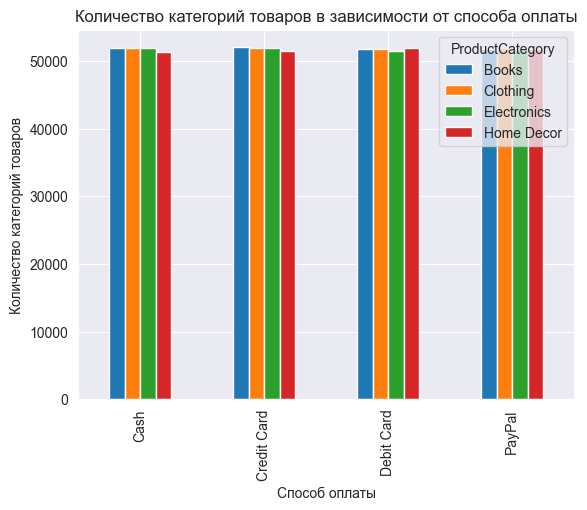

In [ ]:
data_q = data.groupby(['PaymentMethod', 'ProductCategory']).size().unstack(fill_value=0)

plt.figure(figsize = (10, 50))
data_q.plot(kind='bar', stacked=False)
plt.xlabel('Способ оплаты')
plt.ylabel('Количество категорий товаров')
plt.title('Количество категорий товаров в зависимости от способа оплаты')
plt.show()

Что касается количества категорий товаров в отношении способа оплаты, то здесь также заметить, что **дисбаланс данных отсутствует**

In [ ]:
data_q

ProductCategory,Books,Clothing,Electronics,Home Decor
PaymentMethod,,,,
Cash,51970,51907,51840,51298
Credit Card,51995,51867,51933,51430
Debit Card,51735,51787,51431,51898
PayPal,51791,51950,51796,51700


In [ ]:
most_frequent_categories = data_q.idxmax(axis=0)
most_frequent_counts = data_q.max(axis=0)

print("Какой payment method выбирается чаще всего для оплаты n-й категории\n")

for category in most_frequent_categories.index:
    payment_method = most_frequent_categories[category]
    count = most_frequent_counts[category]

    print(f"{Fore.BLUE}{payment_method}{Style.RESET_ALL}: {Fore.LIGHTWHITE_EX}{category}{Style.RESET_ALL}, count = {Fore.CYAN}{count}{Style.RESET_ALL}\n")

Какой payment method выбирается чаще всего для оплаты n-й категории

Credit Card: Books, count = 51995

PayPal: Clothing, count = 51950

Credit Card: Electronics, count = 51933

Debit Card: Home Decor, count = 51898


In [ ]:
data_copy = data.copy()

- **Каков процент транзакций, совершенных в 2023 и 2024 годах?**

In [ ]:
data_copy['Month'] = data_copy['TransactionDate'].dt.month
data_copy['Year'] = data_copy['TransactionDate'].dt.year

In [ ]:
data_copy.groupby('Year')['Month'].unique()

Year
2023    [12, 8, 10, 11, 9, 6, 5, 7, 4, 2, 3, 1]
2024                               [3, 2, 4, 1]
Name: Month, dtype: object

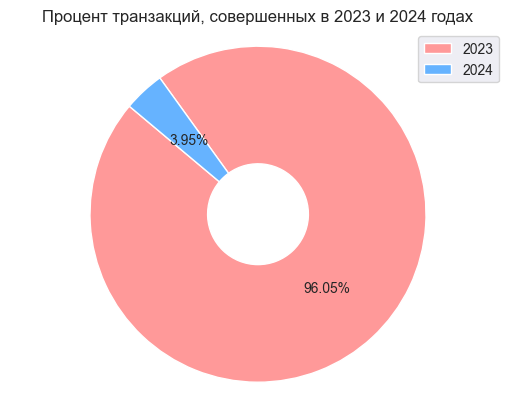

In [ ]:
sizes = data_copy.groupby('Year').size()
colors = ['#ff9999', '#66b3ff']

plt.pie(sizes, autopct='%1.2f%%', startangle=140, colors=colors, wedgeprops=dict(width=0.7))

plt.legend(list(key for key in data_copy['Year'].unique()))
plt.title('Процент транзакций, совершенных в 2023 и 2024 годах')
plt.axis('equal')
plt.show()

**Теперь необходимо получить `статистические характеристики` на наборе данных. НО! Сначала приведем датасет в приемлемый вид**

- Для этого реализуем следующий пайплайн:

привести имена столбцов в нормальный вид

добавим столбец `returning_customer` для обучения классификатора

обновим столбец  `store_location`, заменяя коды местоположений на названия регионов

округлим значения столбца `price`, `discount_applied` до ближайшего целого числа + пересчитаем общую сумму `total_amount` с учетом округленной скидки

создадим новый идентификатор продукта в формате <product_id>-<product_category>

Также отсортируем dataframe по столбцу `transaction_date`, чтобы представить записи транзакций в хронологическом порядке


In [ ]:
website_reference = "https://www.factiva.com/CP_Developer/ProductHelp/FDK/FDK20/registration/shared_code_tables/state_province_table/united_states_state_province_table.htm"

In [ ]:
import re
import pandas_flavor as pf
from typing import Union
from plotnine import *
import janitor
import warnings


warnings.filterwarnings("ignore", category=UserWarning, message="registration of accessor")


__all__ = ["DataPipeline"]


class DataPipeline:
    def __init__(self, input_dataframe):
        self.df = input_dataframe


    @staticmethod
    @pf.register_dataframe_method
    def transform_store_location_to_region(input_df):
        global website_reference

        output_df = input_df.copy()
        region_code_df = pd.read_html(website_reference)[-1]
        region_code_dict = region_code_df.set_index('Code').to_dict()['State/Province']

        def match_and_extract_code(location_string) -> Union[str, float]:
            region_pattern = re.compile(r"(\s[A-Z]{2}\s)")
            match_obj = region_pattern.search(location_string)

            if match_obj:
                _match = match_obj.group(1)
                return _match
            else:
                return np.nan

        region_code_series: pd.Series = input_df.store_location\
            .apply(match_and_extract_code)\
            .str.strip()

        output_df['store_location'] = region_code_series.map(region_code_dict).fillna('Abroad')

        return output_df


    @staticmethod
    @pf.register_dataframe_method
    def clean_discount_feature(input_df) -> pd.DataFrame:
        output_df = input_df.copy()
        clean_discount: pd.Series = input_df['discount_applied'].round(0)
        output_df['discount_applied'] = clean_discount

        return output_df


    @staticmethod
    @pf.register_dataframe_method
    def recalculate_discount_and_total_amount(input_df) -> pd.DataFrame:
        output_df = input_df.copy()
        output_df['price'] = output_df.price.round(2)

        prediscount_total = output_df.quantity * output_df.price
        discount_rate = output_df['discount_applied'].round(0)
        grand_total_amount = prediscount_total - (prediscount_total * (discount_rate / 100))

        output_df['total_amount'] = grand_total_amount.round(2)
        output_df['discount_applied'] = discount_rate

        return output_df


    def run(self) -> pd.DataFrame:
        output = self.df\
            .reorder_columns(['transaction_date', 'customer_id'])\
            .reset_index(drop=True)\
            .transform_store_location_to_region()\
            .recalculate_discount_and_total_amount()\

        return output

In [ ]:
data = data.clean_names(strip_underscores=True, remove_special=True, case_type='snake')

data

,customer_id,product_id,quantity,price,transaction_date,payment_method,store_location,product_category,discount_applied,total_amount
0,109318,C,7,80.079844,2023-12-26 12:32:00,Cash,"176 Andrew Cliffs\nBaileyfort, HI 93354",Books,18.677100,455.862764
1,993229,C,4,75.195229,2023-08-05 00:00:00,Cash,"11635 William Well Suite 809\nEast Kara, MT 19483",Home Decor,14.121365,258.306546
2,579675,A,8,31.528816,2024-03-11 18:51:00,Cash,"910 Mendez Ville Suite 909\nPort Lauraland, MO...",Books,15.943701,212.015651
3,799826,D,5,98.880218,2023-10-27 22:00:00,PayPal,"87522 Sharon Corners Suite 500\nLake Tammy, MO...",Books,6.686337,461.343769
4,121413,A,7,93.188512,2023-12-22 11:38:00,Cash,"0070 Michelle Island Suite 143\nHoland, VA 80142",Electronics,4.030096,626.030484
...,...,...,...,...,...,...,...,...,...,...
828323,510831,A,8,49.171301,2023-07-23 11:34:46,Debit Card,"072 Herman Mountains Apt. 171\nNorth Victoria,...",Books,22.146133,306.254071
828324,510831,D,8,28.620203,2023-09-28 06:35:05,Cash,339 Escobar Vista Suite 380\nPort Cameronville...,Clothing,27.150789,166.796738
828325,23284,C,3,81.703774,2023-08-05 13:31:37,Cash,"291 Maxwell Pines\nAngelaton, PA 47553",Electronics,6.689152,228.715453
828326,23284,B,4,28.307923,2023-06-03 01:03:16,PayPal,"953 Wilson Walks Apt. 371\nNew John, MT 72622",Electronics,18.346694,92.457420


In [ ]:
pipe = DataPipeline(data)

df = pipe.run()

df

,transaction_date,customer_id,product_id,quantity,price,payment_method,store_location,product_category,discount_applied,total_amount
0,2023-12-26 12:32:00,109318,C,7,80.08,Cash,Hawaii,Books,19.0,454.05
1,2023-08-05 00:00:00,993229,C,4,75.20,Cash,Montana,Home Decor,14.0,258.69
2,2024-03-11 18:51:00,579675,A,8,31.53,Cash,Missouri,Books,16.0,211.88
3,2023-10-27 22:00:00,799826,D,5,98.88,PayPal,Missouri,Books,7.0,459.79
4,2023-12-22 11:38:00,121413,A,7,93.19,Cash,Virginia,Electronics,4.0,626.24
...,...,...,...,...,...,...,...,...,...,...
828323,2023-07-23 11:34:46,510831,A,8,49.17,Debit Card,Abroad,Books,22.0,306.82
828324,2023-09-28 06:35:05,510831,D,8,28.62,Cash,Arkansas,Clothing,27.0,167.14
828325,2023-08-05 13:31:37,23284,C,3,81.70,Cash,Pennsylvania,Electronics,7.0,227.94
828326,2023-06-03 01:03:16,23284,B,4,28.31,PayPal,Montana,Electronics,18.0,92.86


In [ ]:
df.isna().sum()

transaction_date    0
customer_id         0
product_id          0
quantity            0
price               0
payment_method      0
store_location      0
product_category    0
discount_applied    0
total_amount        0
dtype: int64

In [ ]:
print(f"{Fore.RED}ДО:{Style.RESET_ALL}")
data["store_location"].head(25)

ДО:


0               176 Andrew Cliffs\nBaileyfort, HI 93354
1     11635 William Well Suite 809\nEast Kara, MT 19483
2     910 Mendez Ville Suite 909\nPort Lauraland, MO...
3     87522 Sharon Corners Suite 500\nLake Tammy, MO...
4      0070 Michelle Island Suite 143\nHoland, VA 80142
5      8492 Jonathan Drive\nNorth Robertshire, TN 67532
6                            USNV Harrell\nFPO AA 62814
7     489 Juan Loop Apt. 093\nNorth Brettville, WV 7...
8     528 Justin Expressway Apt. 336\nCabreraborough...
9                 189 Wright Mews\nMartinfurt, MO 75932
10    388 Matthew Lane Apt. 592\nWest Andreachester,...
11                     PSC 1498, Box 4142\nAPO AP 10928
12      623 William Track Apt. 920\nPort Dave, NE 02045
13    5370 Nichols Fork Suite 983\nGeorgeshire, MT 2...
14    1573 Petty Parkway Apt. 835\nJordanmouth, IN 0...
15    419 Kerr Passage Apt. 443\nMartinezfort, MN 45678
16    1250 Gary Way Apt. 756\nSouth Thomasport, ND 3...
17     73061 Larry Pass Apt. 190\nFischerstad, P

In [ ]:
print(f"{Fore.GREEN}ПОСЛЕ:{Style.RESET_ALL}\n")
df["store_location"].head(25)

ПОСЛЕ:


0            Hawaii
1           Montana
2          Missouri
3          Missouri
4          Virginia
5         Tennessee
6          APO - AA
7     West Virginia
8      South Dakota
9          Missouri
10          Indiana
11         APO - AP
12         Nebraska
13          Montana
14          Indiana
15        Minnesota
16     North Dakota
17           Abroad
18           Abroad
19         Virginia
20      Mississippi
21         Arkansas
22          Wyoming
23     Pennsylvania
24             Ohio
Name: store_location, dtype: object

In [ ]:
len(df["store_location"].unique())

55

In [ ]:
print(df.dtypes)

transaction_date    datetime64[ns]
customer_id                  int64
product_id                  object
quantity                     int64
price                      float64
payment_method              object
store_location              object
product_category            object
discount_applied           float64
total_amount               float64
dtype: object


В  последствие на данном наборе данных, мы будем обучать random forest сегментации клиентов (лояльные клиенты, чувствительные к скидкам, случайные покупатели)

Однако, у нас нет разметки в наших данных под текущую задачу.

Чтобы создать свои собственные метки для обучения модели, я воспользуюсь определенными условными конструкциями (поскольку в данной задаче это более простое и интерпретируемое решение) + данная задача не требует использования более изощренных методов (например: использование алгоритмов кластеризации для разделения клиентов на кластеры)


Но! Прежде, чем приступить к решению данной проблемы, важно получить несколько информативных статистических характеристик по данным. Это позволит лучше понять распределение признаков и выявить возможные проблемы

- Корреляция между количественными признаками

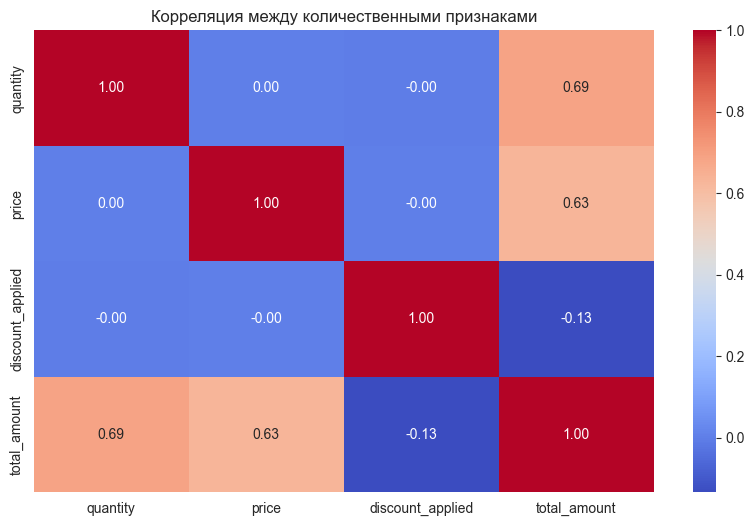

In [ ]:
correlation_matrix = df[['quantity', 'price', 'discount_applied', 'total_amount']].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Корреляция между количественными признаками')
plt.show()

- Наиболее значительные корреляции наблюдаются между quantity и total_amount - около 0.69. Это логично, так как общее количество товаров прямо пропорционально влияет на общую сумму заказа/оплаты покупок

На самом деле, похоже на мультиколлинеарность (не в "классическом" проявлении), но заострять внимание здесь не стоит, так как random Forest, как и другие ансамблевые методы, в меньшей степени страдает от мультиколлинеарности по сравнению с линейными моделями, а мне необходимо использовать именно его.

-----

- price и total_amount - 0.63. Высокая цена также приводит к увеличению общей суммы

- Корреляция между quantity и price равна нулю, что означает, что эти признаки не зависят друг от друга

- discount_applied почти не коррелирует с другими признаками, похоже это указывает на то, что скидки применяются независимо от количества или стоимости товаров

- Распределение количественных признаков

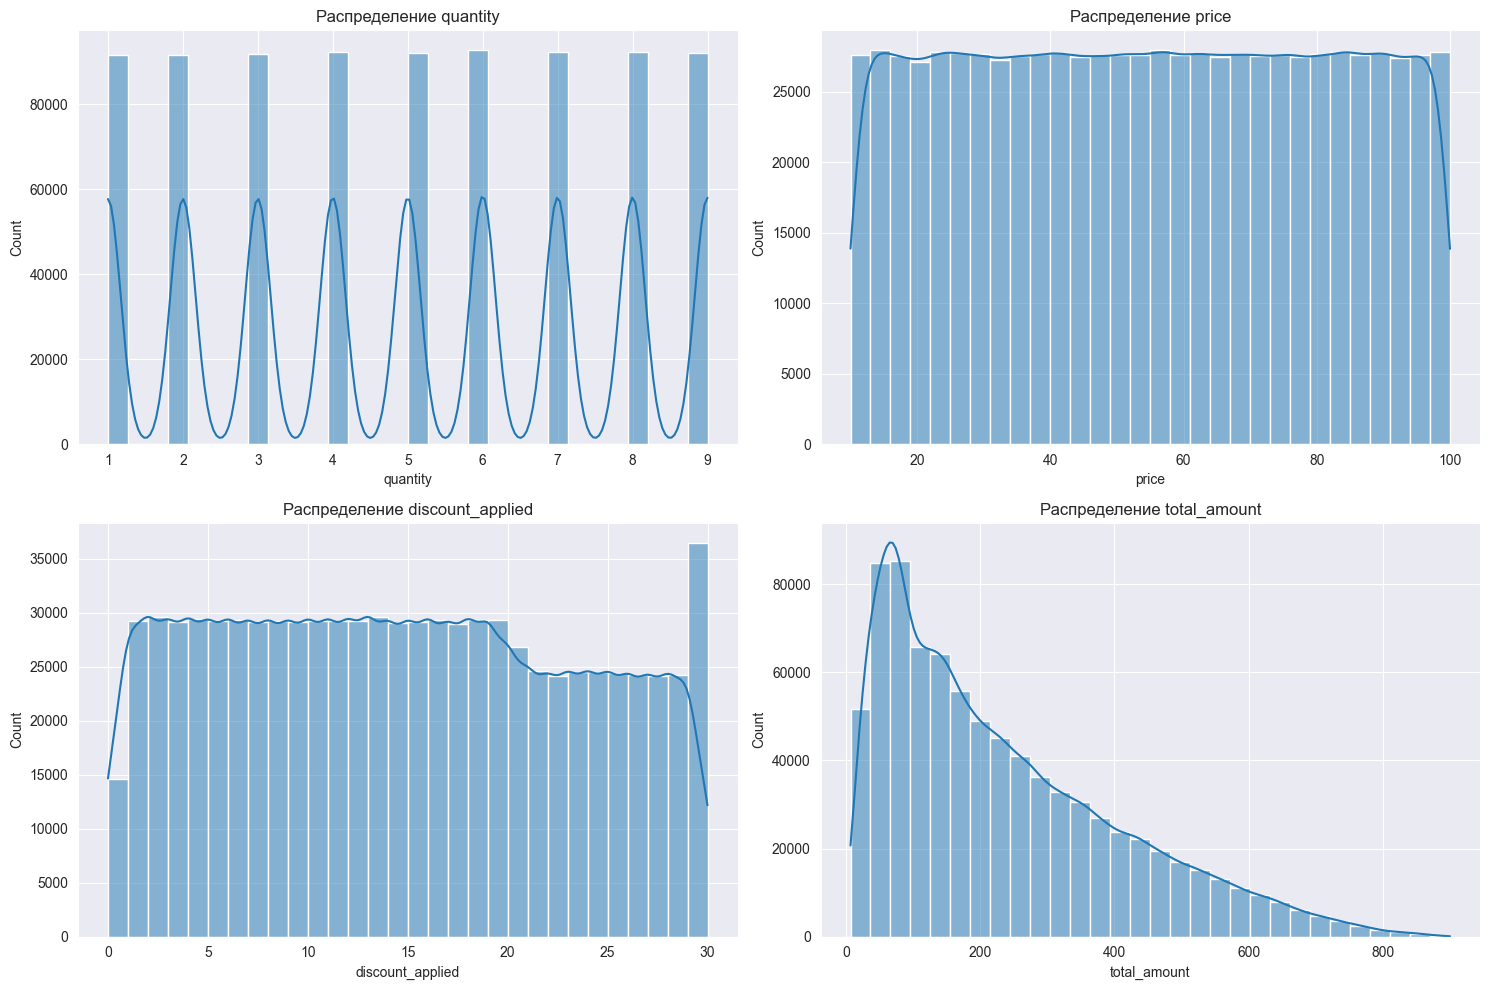

In [ ]:
numerical_columns = ['quantity', 'price', 'discount_applied', 'total_amount']

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Распределение {col}')
plt.tight_layout()
plt.show()


- quantity выглядит цикличным, с пиками на каждом значении от 1 до 9. Наверное, это связано с тем, что количество продуктов ограничено фиксированным кол-во значений
- price более-менее равномерное, с небольшими спадами на крайних значениях (около 20 и 100)
- в discount_applied  распределение почти равномерное, но справа после небольшого спада наблюдается резкий рост транзакций с максимальной скидкой (около 30%). Возможно, это специфическая маркетинговая кампания или акционные товары, на которые распространяется максимальная скидка.
- в total_amount явное смещение распределения в сторону меньших значений.  Большинство покупок имеют небольшую общую сумму, и лишь небольшое число покупок выходит за пределы 400-500

- Сравнение средних и медианных значений

In [ ]:
statistics_summary = df[numerical_columns].describe().T
statistics_summary['median'] = df[numerical_columns].median()
statistics_summary['iqr'] = df[numerical_columns].quantile(0.75) - df[numerical_columns].quantile(0.25)
statistics_summary['skewness'] = df[numerical_columns].skew()
statistics_summary['kurtosis'] = df[numerical_columns].kurtosis()

statistics_summary[['mean', 'median', 'std', 'iqr', 'skewness', 'kurtosis']]

,mean,median,std,iqr,skewness,kurtosis
quantity,5.006011,5.00,2.580156,4.00,-0.003552,-1.228054
price,55.009301,55.04,25.984409,44.98,-0.001116,-1.199349
discount_applied,14.402013,14.00,8.534172,14.00,0.088675,-1.138434
total_amount,235.792745,189.39,176.948789,252.92,0.938937,0.206329


- среднее и медиана практически совпадают для quantity, price, и discount_applied, похоже распределение этих признаков симметрично
- у total_amount среднее значительно выше медианы, что похоже на правую-положительную скошенность
- скошенность у quantity, price, и discount_applied близка к нулю, это говорит о симметричном распределении
- total_amount имеет положительную скошенность, что указывает на присутствие нескольких очень высоких значений

- Топ-10 клиентов с наибольшим числом транзакций

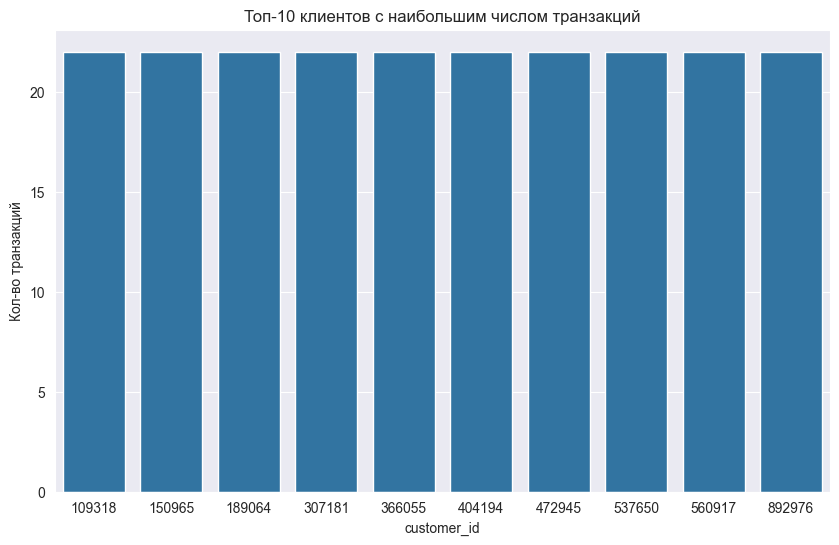

In [ ]:
top_customers = df['customer_id'].value_counts().nlargest(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_customers.index, y=top_customers.values)
plt.xlabel('customer_id')
plt.ylabel('Кол-во транзакций')
plt.title('Топ-10 клиентов с наибольшим числом транзакций')
plt.show()


- **Энкодинг категориальных переменных**

Исходя из того, что для последующего препроцессинга данных мы будем использовать библиотеку PTLS, самостоятельный энкодинг категориальных признаков не требуется, так как он будет выполнен при создании препроцессора (частотный энкодинг)

- **Также преобразуем дату transaction_date в просто номер дня в хронологическом порядке, начиная от заданной даты**

Поскольку это полезно для упрощения обработки данных, в данной задачи точное время суток не так важно. Поэтому достаточно только относительного порядка между событиями.

- тем более это необходимо для совместимости с препроцессором PandasDataPreprocessor, который ожидает в качестве времени события числовое значение


In [ ]:
df['transaction_date'].min()

Timestamp('2023-01-01 00:00:49')

In [ ]:
start_date = np.datetime64('2023-01-01 00:00:49')

df['transaction_date'] = pd.to_datetime(df['transaction_date'])
df['transaction_date'] = (df['transaction_date'] - start_date).dt.days

In [ ]:
df.columns

Index(['transaction_date', 'customer_id', 'product_id', 'quantity', 'price',
       'payment_method', 'store_location', 'product_category',
       'discount_applied', 'total_amount'],
      dtype='object')

- **Отбрасывание лишних столбцов:**

Для сегментации клиентов на "Лояльные клиенты", "Чувствительные к скидкам", "Обычные клиенты" нужно выбрать признаки, которые помогут различить клиентов по их поведению и предпочтениям.

Хотя Random Forest и справляется с большим количеством признаков и шумом, так как он строит множество деревьев и использует случайный подвыбор признаков при построении каждого дерева. Все же явно лишние признаки лучше отбросить, поскольку это может привести, к тому что:

лишние данные будут создавать избыточность и шум, это также может привести к переобучению модели на случайные шумовые паттерны и тд

In [ ]:
df = df.drop(['product_id', 'store_location', 'payment_method'], axis=1)

df

,transaction_date,customer_id,quantity,price,product_category,discount_applied,total_amount
0,359,109318,7,80.08,Books,19.0,454.05
1,215,993229,4,75.20,Home Decor,14.0,258.69
2,435,579675,8,31.53,Books,16.0,211.88
3,299,799826,5,98.88,Books,7.0,459.79
4,355,121413,7,93.19,Electronics,4.0,626.24
...,...,...,...,...,...,...,...
828323,203,510831,8,49.17,Books,22.0,306.82
828324,270,510831,8,28.62,Clothing,27.0,167.14
828325,216,23284,3,81.70,Electronics,7.0,227.94
828326,153,23284,4,28.31,Electronics,18.0,92.86


In [ ]:
df.to_csv('../../src/data/custom_RetailTransaction_dataset.csv', index=False)

In [3]:
df = pd.read_csv("../../src/data/custom_RetailTransaction_dataset.csv", sep=',')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 828328 entries, 0 to 828327
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   transaction_date  828328 non-null  int64  
 1   customer_id       828328 non-null  int64  
 2   quantity          828328 non-null  int64  
 3   price             828328 non-null  float64
 4   product_category  828328 non-null  object 
 5   discount_applied  828328 non-null  float64
 6   total_amount      828328 non-null  float64
dtypes: float64(3), int64(3), object(1)
memory usage: 44.2+ MB


- **Разметка датасета:**

Теперь можно приступить к созданию собственных меток (клиент: loyal (2), bargain hunter (1), обычный (0)), сохранив их потом в отдельном таргет csv файле в формате:

`customer_id`: `target`


условные конструкции для присваивания меток:


In [ ]:
customer_summary = df.groupby('customer_id').agg(
    total_quantity=('quantity', 'sum'),
    total_spent=('total_amount', 'sum'),
    discount_used=('discount_applied', 'mean'),
    num_transactions=('transaction_date', 'count')
).reset_index()

# mean
mean_spent = customer_summary['total_spent'].mean()
mean_quantity = customer_summary['total_quantity'].mean()
mean_discount = customer_summary['discount_used'].mean()
mean_transactions = customer_summary['num_transactions'].mean()

In [ ]:
def assign_label(row):
    if row['num_transactions'] > mean_transactions and row['total_spent'] > mean_spent and row['discount_used'] < mean_discount:
        return 2  # Loyal
    elif row['discount_used'] > mean_discount and row['total_spent'] <= mean_spent:
        return 1  # Bargain hunters
    else:
        return 0  # Regular

In [ ]:
customer_summary['target'] = customer_summary.apply(assign_label, axis=1)

target_df = customer_summary[['customer_id', 'target']]
target_df.to_csv("../../src/data/target_TransactionRetail.csv", index=False)

print("Таргетные метки успешно созданы и сохранены!")

Таргетные метки успешно созданы и сохранены!


- **Проверим на дисбаланс по соотношению каждой из меток

In [ ]:
test = pd.read_csv("../../src/data/target_TransactionRetail.csv", sep=',')

In [ ]:
label_counts = test['target'].value_counts()
label_percentages = test['target'].value_counts(normalize=True) * 100


print("Количество каждой метки:")
print(label_counts)
print("\nПроцентное соотношение каждой метки:")
print(label_percentages)


Количество каждой метки:
target
0    55698
1    27606
2    11911
Name: count, dtype: int64

Процентное соотношение каждой метки:
target
0    58.497086
1    28.993331
2    12.509584
Name: proportion, dtype: float64


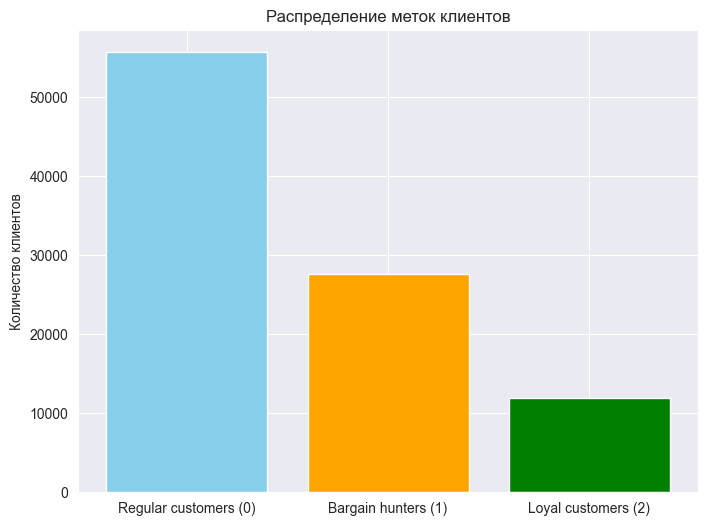

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts.values, color=['skyblue', 'orange', 'green'])
plt.xticks(label_counts.index, ['Regular customers (0)', 'Bargain hunters (1)', 'Loyal customers (2)'])
plt.ylabel('Количество клиентов')
plt.title('Распределение меток клиентов')
plt.show()

Да, в данной ситуации наблюдается дисбаланс данных между классами, необходимо принять меры, поскольку дисбаланс в данных может повлиять на качество обучение модели (смещение в сторону доминирующего класса), особенно если модель чувствительна к различиям в количестве образцов для каждого класса.

- Но в целом, распределение классов лучше сбалансировано, чем в большинстве реальных задач, но дисбаланс все же виден достаточно явно

-----

Для эффективной борьбы с дисбалансом классов, я думаю воспользоваться методом взвешивания классов class weight (более сильные штрафы за ошибки в классе-меньшинстве) и возможно протестировать кросс-валидацию с учетом стратификации, и вот почему:

- `Undersampling` может привести к потере важных данных, что плохо отразится на обобщающей способности модели в контексте моей задачи.

- `Oversampling` может привести к переобучению модели, так как он увеличивает размер выборки за счет дублирования данных миноритарного класса


## 2. **Data preprocessing**

-----

Выполним предобработку данных (последовательностей событий) с использованием библиотеки ptls и класса PandasDataPreprocessor


In [4]:
df.columns

Index(['transaction_date', 'customer_id', 'quantity', 'price',
       'product_category', 'discount_applied', 'total_amount'],
      dtype='object')

In [5]:
from ptls.preprocessing import PandasDataPreprocessor

preprocessor = PandasDataPreprocessor(
    col_id='customer_id',
    col_event_time='transaction_date',
    event_time_transformation='none',
    cols_category=['product_category'],
    category_transformation='frequency',
    cols_numerical=['quantity', 'price', 'discount_applied', 'total_amount'],
    return_records=True
)

In [6]:
%%time

dataset = preprocessor.fit_transform(df)

CPU times: total: 12.1 s
Wall time: 30.2 s


In [7]:
dataset[:1]

[{'customer_id': 14,
  'transaction_date': tensor([ 14,  69,  72,  79, 106, 217, 222, 232, 266, 273]),
  'event_time': tensor([ 14,  69,  72,  79, 106, 217, 222, 232, 266, 273]),
  'product_category': tensor([1, 3, 4, 4, 1, 2, 4, 4, 2, 3]),
  'quantity': tensor([1, 8, 6, 1, 2, 5, 6, 9, 8, 4]),
  'price': tensor([96.4300, 54.1800, 40.5900, 70.2600, 23.7800, 60.6500, 92.3200, 26.9400,
          23.8000, 26.5600], dtype=torch.float64),
  'discount_applied': tensor([ 5., 21., 12., 20., 24., 16.,  8., 16.,  5., 27.], dtype=torch.float64),
  'total_amount': tensor([ 91.6100, 342.4200, 214.3200,  56.2100,  36.1500, 254.7300, 509.6100,
          203.6700, 180.8800,  77.5600], dtype=torch.float64)}]

- **сохраним состояние препроцессора**

In [8]:
import pickle

with open('preprocessor.p', 'wb') as f:
    pickle.dump(preprocessor, f)

- **разделим набор данных на train validation test выборки**

In [9]:
from sklearn.model_selection import train_test_split

train_temp, test = train_test_split(dataset, test_size=0.2, random_state=42)
train, val = train_test_split(train_temp, test_size=0.25, random_state=42)

print(f"Train: {len(train)}\n"
      f"Test: {len(test)}\n"
      f"Validation: {len(val)}\n")

Train: 57129
Test: 19043
Validation: 19043


In [11]:
train[0], test[0], val[0]

({'customer_id': 646472,
  'transaction_date': tensor([ 13,  17,  19,  22,  53,  74,  80,  89,  91,  97, 113, 168, 214, 222,
          225, 233, 281, 293, 295, 308, 314, 329]),
  'event_time': tensor([ 13,  17,  19,  22,  53,  74,  80,  89,  91,  97, 113, 168, 214, 222,
          225, 233, 281, 293, 295, 308, 314, 329]),
  'product_category': tensor([1, 1, 4, 1, 3, 2, 3, 4, 1, 3, 3, 4, 3, 3, 4, 2, 3, 3, 1, 4, 2, 2]),
  'quantity': tensor([4, 8, 5, 9, 3, 5, 8, 3, 5, 4, 3, 6, 9, 5, 2, 5, 9, 2, 7, 1, 9, 9]),
  'price': tensor([36.0800, 73.8600, 97.2100, 69.7500, 81.8800, 50.0300, 30.8100, 42.8500,
          35.2600, 92.1200, 13.7800, 63.6100, 54.3600, 38.8500, 31.8500, 56.9400,
          54.2500, 56.2300, 17.2900, 50.6500, 88.6800, 51.4300],
         dtype=torch.float64),
  'discount_applied': tensor([11., 10., 30., 12.,  9., 24., 16.,  6., 17.,  1., 22., 20.,  2., 28.,
          23.,  3., 30., 15.,  1., 19., 24.,  8.], dtype=torch.float64),
  'total_amount': tensor([128.4400, 531.7900, 3

In [12]:
from functools import partial
from ptls.nn import TrxEncoder, RnnSeqEncoder
from ptls.frames.coles import CoLESModule
import torch

trx_encoder_params = dict(
    embeddings_noise=0.003,
    numeric_values={
        'price': 'identity',
        'quantity': 'identity',
        'discount_applied': 'identity',
        'total_amount': 'identity'
    },
    embeddings={
        'transaction_date': {'in': 500, 'out': 16},
        'product_category': {'in': 128, 'out': 16},
    },
)


seq_encoder = RnnSeqEncoder(
    trx_encoder=TrxEncoder(**trx_encoder_params),
    hidden_size=256,
    type='gru',
)


model = CoLESModule(
    seq_encoder=seq_encoder,
    optimizer_partial=partial(
        torch.optim.Adam,
        lr=0.001,
        # weight_decay=1e-5 # Добавлена L2 регуляризация
    ),
    lr_scheduler_partial=partial(torch.optim.lr_scheduler.StepLR, step_size=30, gamma=0.9),
)

- **создадим DataModule + *с шагом проверки (валидации) для training***

-----

- **создадим DataModule для test, чтобы после обучения провести оценку**

In [13]:
len(train), len(test), len(val)

(57129, 19043, 19043)

In [14]:
train[0]

{'customer_id': 646472,
 'transaction_date': tensor([ 13,  17,  19,  22,  53,  74,  80,  89,  91,  97, 113, 168, 214, 222,
         225, 233, 281, 293, 295, 308, 314, 329]),
 'event_time': tensor([ 13,  17,  19,  22,  53,  74,  80,  89,  91,  97, 113, 168, 214, 222,
         225, 233, 281, 293, 295, 308, 314, 329]),
 'product_category': tensor([1, 1, 4, 1, 3, 2, 3, 4, 1, 3, 3, 4, 3, 3, 4, 2, 3, 3, 1, 4, 2, 2]),
 'quantity': tensor([4, 8, 5, 9, 3, 5, 8, 3, 5, 4, 3, 6, 9, 5, 2, 5, 9, 2, 7, 1, 9, 9]),
 'price': tensor([36.0800, 73.8600, 97.2100, 69.7500, 81.8800, 50.0300, 30.8100, 42.8500,
         35.2600, 92.1200, 13.7800, 63.6100, 54.3600, 38.8500, 31.8500, 56.9400,
         54.2500, 56.2300, 17.2900, 50.6500, 88.6800, 51.4300],
        dtype=torch.float64),
 'discount_applied': tensor([11., 10., 30., 12.,  9., 24., 16.,  6., 17.,  1., 22., 20.,  2., 28.,
         23.,  3., 30., 15.,  1., 19., 24.,  8.], dtype=torch.float64),
 'total_amount': tensor([128.4400, 531.7900, 340.2400, 552.4

In [15]:
from ptls.data_load.datasets import MemoryMapDataset
from ptls.data_load.iterable_processing import SeqLenFilter
from ptls.frames.coles import ColesDataset
from ptls.frames.coles.split_strategy import SampleSlices
from ptls.frames import PtlsDataModule


# для обучения + валидации
train_dl = PtlsDataModule(
    train_data=ColesDataset(
        MemoryMapDataset(
            data=train,
            i_filters=[SeqLenFilter(min_seq_len=5)],
        ),
        splitter=SampleSlices(split_count=5, cnt_min=3, cnt_max=20),

    ),
    valid_data=ColesDataset(
        MemoryMapDataset(
            data=val,
            i_filters=[SeqLenFilter(min_seq_len=5)],
        ),
        splitter=SampleSlices(split_count=5, cnt_min=3, cnt_max=20),
    ),
    valid_num_workers=16,
    valid_batch_size=256,
    train_num_workers=16,
    train_batch_size=256,
)

# для тестирования
test_dl = PtlsDataModule(
    test_data=ColesDataset(
        MemoryMapDataset(
            data=test,
            i_filters=[SeqLenFilter(min_seq_len=5)],
        ),
        splitter=SampleSlices(split_count=5, cnt_min=3, cnt_max=20),
    ),
    test_num_workers=16,
    test_batch_size=256,
)

In [16]:
print(len(train_dl.train_dataloader().dataset))

28558


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


**Добавим логирование метрик эпохи обучения**

In [17]:
import pytorch_lightning as pl
from colorama import Fore, Style

class MetricLoggingCallback(pl.Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        print(f"\nEpoch {Fore.LIGHTBLUE_EX}{trainer.current_epoch}{Style.RESET_ALL}:\n"
              f"-------------------------\n"
              f"valid/recall_top_k: {Fore.LIGHTYELLOW_EX}{trainer.callback_metrics['valid/recall_top_k']:.3f}{Style.RESET_ALL}\n"
              f"loss: {Fore.LIGHTYELLOW_EX}{trainer.callback_metrics['loss']:.3f}{Style.RESET_ALL}\n"
              f"-------------------------\n\n")

**Также в trainer добавим коллбэки для early stopping (для борьбы с переобучением) и логирование метрик**

In [18]:
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

early_stop_callback = EarlyStopping(
    monitor='loss',
    min_delta=0.00,
    patience=3,
    verbose=True,
    mode='min'
)

trainer = pl.Trainer(
    max_epochs=15,
    accelerator="cuda" if torch.cuda.is_available() else "cpu",
    devices=1 if torch.cuda.is_available() else "auto",
    callbacks=[early_stop_callback, MetricLoggingCallback()],
    enable_progress_bar=True,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [19]:
%%time
trainer.fit(
    model=model,
    datamodule=train_dl
)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type            | Params | Mode 
---------------------------------------------------------------
0 | _loss              | ContrastiveLoss | 0      | train
1 | _seq_encoder       | RnnSeqEncoder   | 236 K  | train
2 | _validation_metric | BatchRecallTopK | 0      | train
3 | _head              | Head            | 0      | train
---------------------------------------------------------------
236 K     Trainable params
0         Non-trainable params
236 K     Total params
0.944     Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric loss improved. New best score: 236.631



Epoch 0:
-------------------------
valid/recall_top_k: 0.618
loss: 236.631
-------------------------



Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric loss improved by 31.072 >= min_delta = 0.0. New best score: 205.559



Epoch 1:
-------------------------
valid/recall_top_k: 0.697
loss: 205.559
-------------------------



Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric loss improved by 35.529 >= min_delta = 0.0. New best score: 170.030



Epoch 2:
-------------------------
valid/recall_top_k: 0.767
loss: 170.030
-------------------------



Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 3:
-------------------------
valid/recall_top_k: 0.801
loss: 174.483
-------------------------



Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric loss improved by 0.725 >= min_delta = 0.0. New best score: 169.304



Epoch 4:
-------------------------
valid/recall_top_k: 0.821
loss: 169.304
-------------------------



Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric loss improved by 12.901 >= min_delta = 0.0. New best score: 156.403



Epoch 5:
-------------------------
valid/recall_top_k: 0.830
loss: 156.403
-------------------------



Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 6:
-------------------------
valid/recall_top_k: 0.836
loss: 162.777
-------------------------



Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric loss improved by 2.294 >= min_delta = 0.0. New best score: 154.109



Epoch 7:
-------------------------
valid/recall_top_k: 0.842
loss: 154.109
-------------------------



Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric loss improved by 9.460 >= min_delta = 0.0. New best score: 144.650



Epoch 8:
-------------------------
valid/recall_top_k: 0.843
loss: 144.650
-------------------------



Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric loss improved by 0.403 >= min_delta = 0.0. New best score: 144.247



Epoch 9:
-------------------------
valid/recall_top_k: 0.851
loss: 144.247
-------------------------



Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric loss improved by 4.160 >= min_delta = 0.0. New best score: 140.087



Epoch 10:
-------------------------
valid/recall_top_k: 0.849
loss: 140.087
-------------------------



Validation: |          | 0/? [00:00<?, ?it/s]


Epoch 11:
-------------------------
valid/recall_top_k: 0.853
loss: 150.336
-------------------------



Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric loss improved by 1.085 >= min_delta = 0.0. New best score: 139.001



Epoch 12:
-------------------------
valid/recall_top_k: 0.854
loss: 139.001
-------------------------



Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric loss improved by 5.763 >= min_delta = 0.0. New best score: 133.238



Epoch 13:
-------------------------
valid/recall_top_k: 0.853
loss: 133.238
-------------------------



Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.



Epoch 14:
-------------------------
valid/recall_top_k: 0.855
loss: 136.579
-------------------------


CPU times: user 2min 56s, sys: 28.1 s, total: 3min 24s
Wall time: 12min 53s


In [20]:
torch.save(seq_encoder.state_dict(), "rt-emb.pt")

**Протестируем обученную модель:**

- расширим CoLESModule, чтобы добавить возможность тестирования модели с использованием метода test_step()
- загрузим веса
- выполним тест

In [41]:
class ExtendedCoLESModule(CoLESModule):
    def __init__(self, seq_encoder, optimizer_partial, lr_scheduler_partial, head=None, loss=None, validation_metric=None):
        super().__init__(
            seq_encoder=seq_encoder,
            head=head,
            loss=loss,
            validation_metric=validation_metric,
            optimizer_partial=optimizer_partial,
            lr_scheduler_partial=lr_scheduler_partial
        )

    def test_step(self, batch, batch_idx):
        inputs, labels = batch

        y_h, y = self.shared_step(inputs, labels)
        recall_top_k = self._validation_metric(y_h, y)
        self.log('test/recall_top_k', recall_top_k, prog_bar=True)

        return {'test/recall_top_k': recall_top_k}


In [42]:
seq_encoder = RnnSeqEncoder(
    trx_encoder=TrxEncoder(**trx_encoder_params),
    hidden_size=256,
    type='gru',
)


seq_encoder.load_state_dict(torch.load("rt-emb.pt"))

<ipython-input-42-0a00ef0593dd>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  seq_encoder.load_state_dict(torch.load("rt-emb.pt"))


<All keys matched successfully>

In [43]:
extended_model = ExtendedCoLESModule(
    seq_encoder=seq_encoder,
    optimizer_partial=partial(
        torch.optim.Adam,
        lr=0.001,
    ),
    lr_scheduler_partial=partial(torch.optim.lr_scheduler.StepLR, step_size=30, gamma=0.9),
)


trainer.test(
    model=extended_model,
    datamodule=test_dl
)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     test/recall_top_k     │    0.8543421030044556     │
└───────────────────────────┴───────────────────────────┘

[{'test/recall_top_k': 0.8543421030044556}]

- **Выполним инференс эмбеддингов для тренировочных и тестовых данных**

In [13]:
seq_encoder = RnnSeqEncoder(
    trx_encoder=TrxEncoder(**trx_encoder_params),
    hidden_size=256,
    type='gru',
)


seq_encoder.load_state_dict(torch.load("../../src/model_weights/rt-emb.pt"))


model = CoLESModule(
    seq_encoder=seq_encoder,
    optimizer_partial=partial(
        torch.optim.Adam,
        lr=0.001,
    ),
    lr_scheduler_partial=partial(torch.optim.lr_scheduler.StepLR, step_size=30, gamma=0.9),
)

C:\Users\nikdf\AppData\Local\Temp\ipykernel_19984\1123104947.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  seq_encoder.load_state_dict(torch.load("../../src/model_weig

In [15]:
from ptls.data_load.datasets import inference_data_loader


trainer = pl.Trainer(
    max_epochs=15,
    accelerator="cuda" if torch.cuda.is_available() else "cpu",
    devices=1 if torch.cuda.is_available() else "auto",
    enable_progress_bar=True,
)

train_dl = inference_data_loader(train, num_workers=0, batch_size=256)
train_embeds = torch.vstack(trainer.predict(model, train_dl, ))

test_dl = inference_data_loader(test, num_workers=0, batch_size=256)
test_embeds = torch.vstack(trainer.predict(model, test_dl))


train_embeds.shape, test_embeds.shape

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\nikdf\PycharmProjects\sber_ai_lab_task\.venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

(torch.Size([57129, 256]), torch.Size([19043, 256]))

In [16]:
df_target = pd.read_csv('../../src/data/target_TransactionRetail.csv')

df_target

,customer_id,target
0,14,1
1,42,2
2,49,1
3,59,2
4,65,0
...,...,...
95210,999910,1
95211,999931,0
95212,999977,1
95213,999990,2


In [17]:
df_target = df_target.set_index('customer_id')

train_df = pd.DataFrame(data=train_embeds, columns=[f'embed_{i}' for i in range(train_embeds.shape[1])])
train_df['customer_id'] = [x['customer_id'] for x in train]
train_df = train_df.merge(df_target, how='left', on='customer_id')

test_df = pd.DataFrame(data=test_embeds, columns=[f'embed_{i}' for i in range(test_embeds.shape[1])])
test_df['customer_id'] = [x['customer_id'] for x in test]
test_df = test_df.merge(df_target, how='left', on='customer_id')


train_df.shape, test_df.shape

((57129, 258), (19043, 258))

**Обучим random forest на основе полученных эмбеддингов для сегментации клиентов по их покупательскому поведению (чтобы в последствие можно было предлагать наиболее релевантные предложения)**

Как я уже упоминал ранее, для решения проблемы дисбаланса классов будет использована кросс-валидация с учетом стратификации и class weight

- для этого поделим это на 2 эксперимента

-----

Дополнительно, я решил применить grid search для поиска оптимальных гиперпараметров

#### Эксперимент №1: **со стратифицированной кросс-валидацией**

In [18]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score


embed_columns = [x for x in train_df.columns if x.startswith('embed')]
X_train, y_train = train_df[embed_columns], train_df['target']

X_test, y_test = test_df[embed_columns], test_df['target']


stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
}


rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           scoring='accuracy', cv=stratified_kfold, n_jobs=-1)


grid_search.fit(X_train, y_train)


print("Best parameters found: ", grid_search.best_params_)

# predict
y_pred = grid_search.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {test_accuracy:.4f}')

# summary
print(classification_report(y_test, y_pred))

Best parameters found:  {'max_depth': None, 'n_estimators': 200}
Test Accuracy: 0.7735
              precision    recall  f1-score   support

           0       0.74      0.94      0.83     11123
           1       0.87      0.62      0.73      5556
           2       0.84      0.33      0.47      2364

    accuracy                           0.77     19043
   macro avg       0.82      0.63      0.68     19043
weighted avg       0.79      0.77      0.76     19043


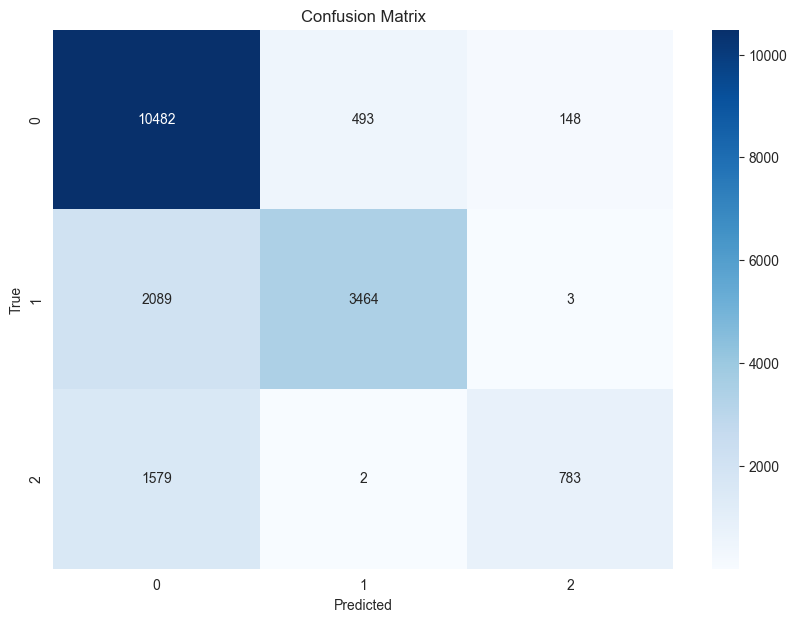

In [28]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['0', '1', '2'], 
            yticklabels=['0', '1', '2'])
plt.ylabel('True')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

**Вывод касательно первого эксперимента:**
-----

- сначала по матрице ошибок

TP00=`10482`, FP01=493, FP02=148
FN10=2089, TP11=`3464`, FP12=3
FN20=1579, FN21=2, TP22=`783`

В целом результат средний, безусловно еще есть над чем работать, все-таки дисбаланс классов, мне кажется, сказался на итоговом результате предсказательной способности алгоритма

Возможно стоит попробовать эксперимент с генерированием синтетических данных

----- 

accuracy на тестовой выборке составила: `~77.3%`

#### Эксперимент №2: **с class weight**

In [31]:
embed_columns = [x for x in train_df.columns if x.startswith('embed')]
X_train, y_train = train_df[embed_columns], train_df['target']

X_test, y_test = test_df[embed_columns], test_df['target']


param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'class_weight': ['balanced']
}


rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           scoring='accuracy', cv=5, n_jobs=-1, verbose=2)


grid_search.fit(X_train, y_train)


print("\nBest parameters found: ", grid_search.best_params_)


# predict
y_pred = grid_search.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f'\nTest Accuracy: {test_accuracy:.4f}\n')

# summary
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best parameters found:  {'class_weight': 'balanced', 'max_depth': 20, 'n_estimators': 200}

Test Accuracy: 0.7834

              precision    recall  f1-score   support

           0       0.76      0.92      0.83     11123
           1       0.87      0.63      0.73      5556
           2       0.77      0.49      0.60      2364

    accuracy                           0.78     19043
   macro avg       0.80      0.68      0.72     19043
weighted avg       0.79      0.78      0.77     19043


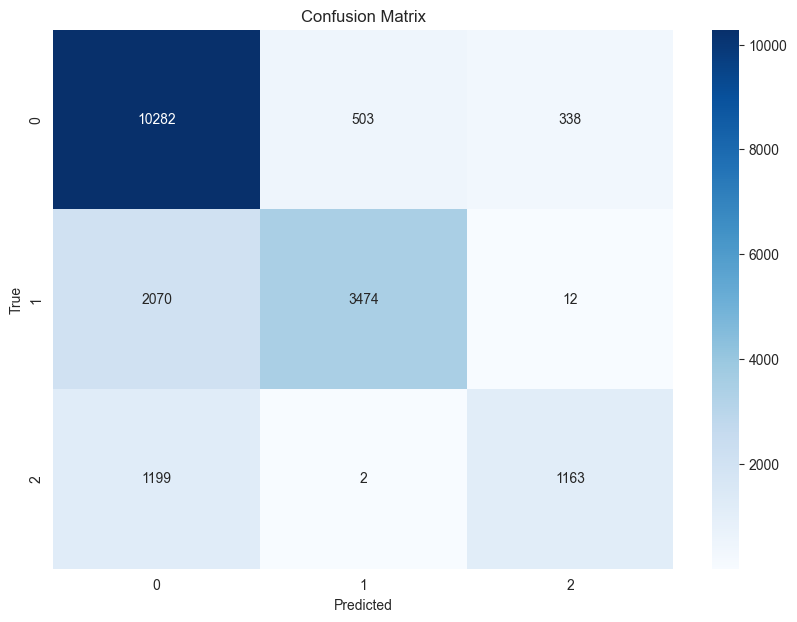

In [32]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['0', '1', '2'], 
            yticklabels=['0', '1', '2'])
plt.ylabel('True')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

**Вывод касательно второго эксперимента:**
-----

Хмм, использование class weight для борьбы с дисбалансом классов показало чуть лучший результат в сравнение с первым экспериментом, однако распределение по классам всё ещё оставляет желать лучшего

Все-таки стоит поработать с набором данных, чтобы сбалансировать классы перед обучением random forest

И думаю стоит уделить внимание oversampling и undersampling и посмотреть на результаты обучения

А также попробовать другие ансамблевые методы (градиентный бустинг)

----- 

accuracy на тестовой выборке составила: `~78.3%`